In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm

# Объявление классов и функций

## Класс для теста функций

In [3]:
class BenchmarkFunction:
    def __init__(self, 
                 name: str, 
                 bounds: np.ndarray,
                 global_min: np.ndarray,
                 function: callable) -> None:
        """Инициализация класса функции

        Args:
            name (str): Имя функции
            bounds (np.ndarray): Границы функции
            global_min (np.ndarray): Глобальный минимум
            function (callable): Функция
        """
        self.name = name
        self.bounds = bounds
        self.global_min = np.append(global_min, function(global_min))
        self.function = function

    def grad(self,
             point: np.ndarray,
             dt: float=0.0001) -> np.ndarray:
        dx = (self.function(point - np.array([dt, 0])) - self.function(point)) / dt
        dy = (self.function(point - np.array([0, dt])) - self.function(point)) / dt

        return np.array([-dx, -dy])
        

In [17]:
def draw_result(func: BenchmarkFunction,
                path: np.ndarray=None) -> None:
    """Функция для отрисовки графика функции

    Args:
        func (BenchmarkFunction): Тестируемая функция
        path (np.ndarray, optional): Путь прохождения градиентного спуска. Defaults to None.
    """

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection = '3d')
    
    x = np.linspace(func.bounds[0, 0], func.bounds[1, 0], 100)
    y = np.linspace(func.bounds[0, 1], func.bounds[1, 1], 100)
    
    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = func.function(np.array([x_grid, y_grid]))
    
    
    if path is not None:
        ax.plot(path[:, 0], path[:, 1], path[:, 2], '-o', c='black', label = 'Градиентный спуск', alpha = 0.7)
        ax.scatter3D(path[0, 0], path[0, 1], path[0, 2], s=100, c="white", lw=2, ec='black', marker = 'D', label="Начальная точка")
        ax.scatter3D(path[-1, 0], path[-1, 1], path[-1, 2], s=190, c="white", lw=2, ec='black', marker = 'X', label="Найденный минимум")
        np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
        print(f"Начальная точка:\t{path[0]}")
        np.set_printoptions(formatter={'float_kind':"{:.2e}".format})
        print(f"Найденный минимум:\t{path[-1]}")
        print(f"Кол-во итераций:\t{len(path)}")
        fig.text(0.9, 0.1, s=f"Кол-во итераций: {len(path)}", horizontalalignment="right", fontsize = 12)

    ax.plot_surface(x_grid, y_grid, z_grid, cmap='Spectral', alpha=0.5) 
    ax.scatter3D(*func.global_min, s=150, c="red", lw=2, ec='black', marker = 'o', label="Глобальный минимум", alpha = 0.7)
    print(f"Глобальный минимум:\t{func.global_min}")

    ax.set_title(func.name, fontsize = 12, fontweight="bold",loc="left")
    ax.legend(loc="upper left")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Объявление классов проблем

## Функция Бута

In [11]:
Booth = BenchmarkFunction(
    name="Функция Бута",
    bounds=np.array([[-10, -10], [10, 10]]),
    global_min=np.array([1., 3.]),
    function=lambda X: (X[0] + 2 * X[1] - 7) ** 2 + (2 * X[0] + X[1] - 5) ** 2
)

Глобальный минимум:	[1. 3. 0.]


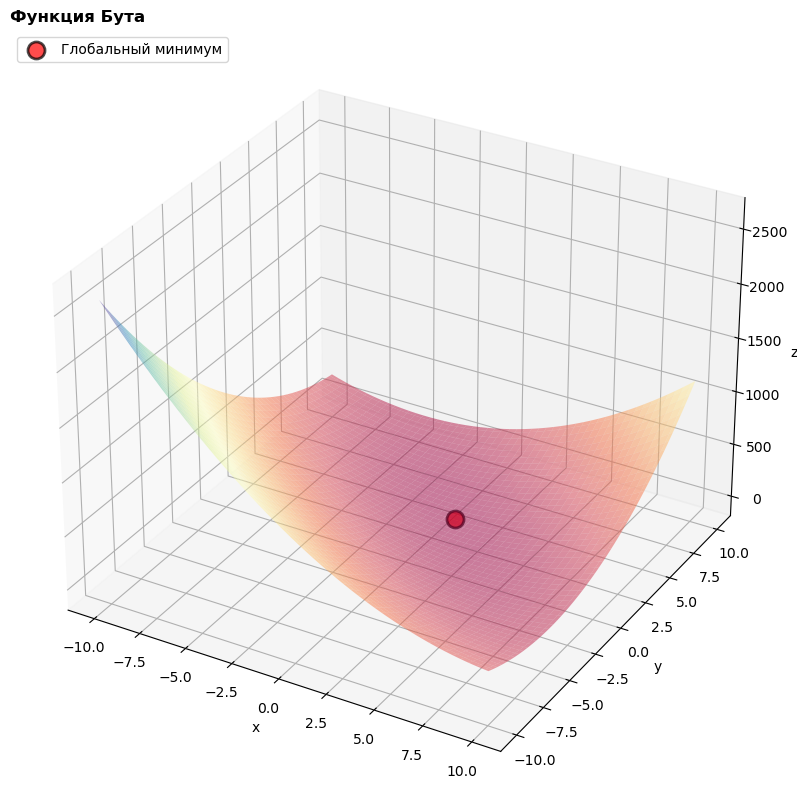

In [18]:
draw_result(Booth)

## Функция Матьяса

In [9]:
Matyas = BenchmarkFunction(
    name="Функция Матьяса",
    bounds=np.array([[-10, -10], [10, 10]]),
    global_min=np.array([0, 0]),
    function=lambda X: 0.26 * (X[0] ** 2 + X[1] ** 2) - 0.48 * X[0] * X[1]
)

Глобальный минимум:	[0. 0. 0.]


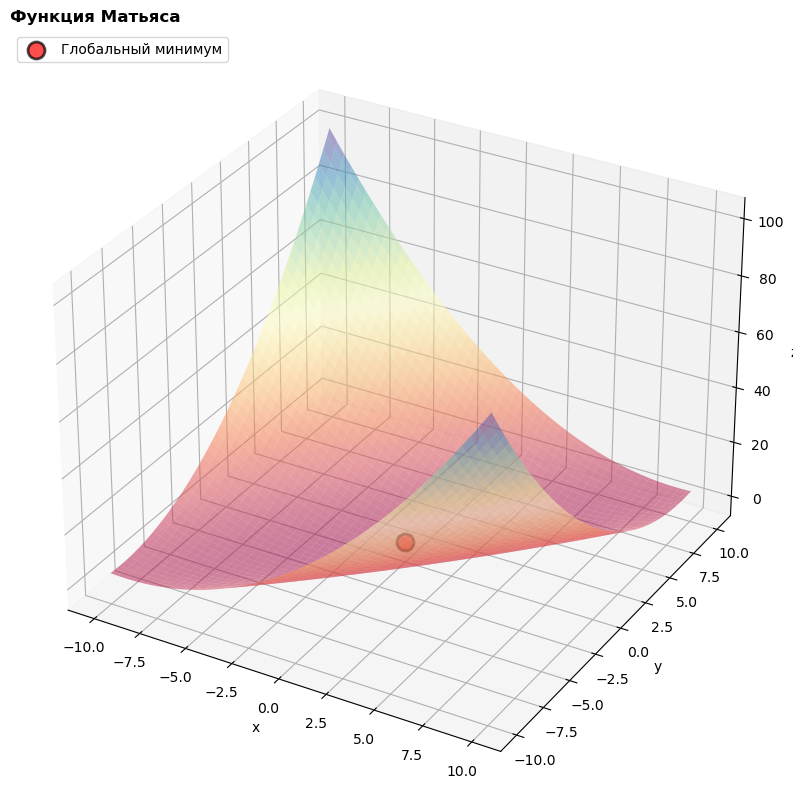

In [19]:
draw_result(Matyas)

# Функции градиентного спуска

## Классический градиентный спуск

In [37]:
def classic_GD(
    func: BenchmarkFunction, 
    start_params: np.ndarray, 
    max_iter: int = 10000, 
    lr: float = 0.001, 
    delta: float = 0.001
    ) -> np.array:

    params = start_params.copy()
    path = [np.array([params[0], params[1], func.function(params)])]
    
    step = 0
    while (step < max_iter and norm(path[-1] - func.global_min) > delta):
        params = params - lr * func.grad(params)
        
        path.append(np.array([params[0], params[1], func.function(params)]))
        step += 1

    return np.array(path)

### Тестирование классического градиентного спуска на функции Бута

Начальная точка:	[-7.00 -7.00 1460.00]
Найденный минимум:	[1.00e+00 3.00e+00 1.01e-06]
Кол-во итераций:	3625
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]


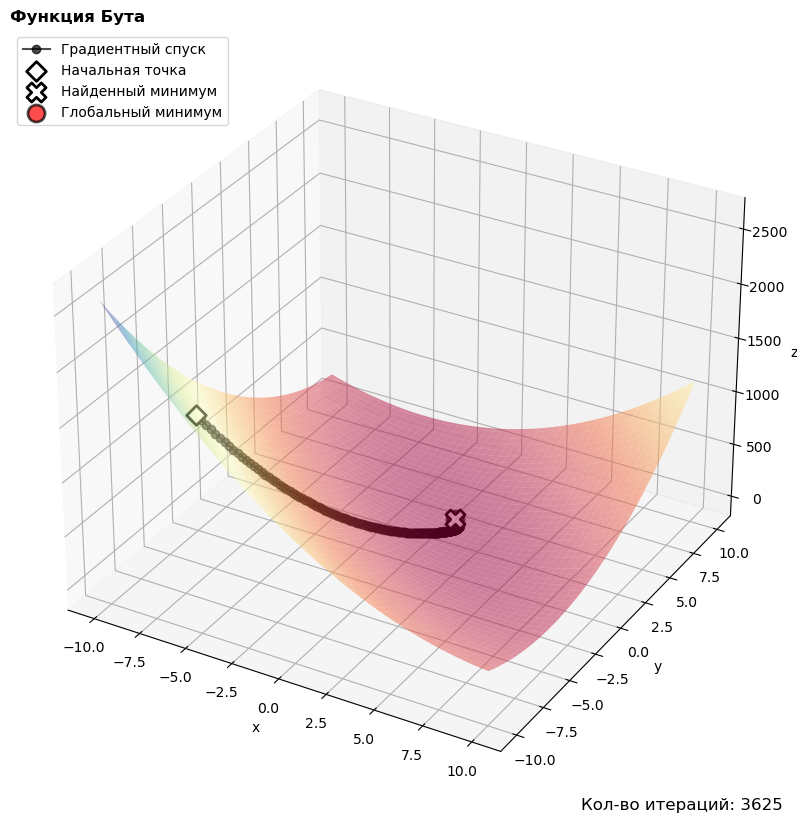

In [38]:
path = classic_GD(Booth,
                  start_params=np.array([-7, -7]))

draw_result(Booth, path)

### Тестирование классического градиентного спуска на функции Матьяса

Начальная точка:	[-9.00 5.00 49.16]
Найденный минимум:	[-7.07e-04 -7.07e-04 2.00e-08]
Кол-во итераций:	182395
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]


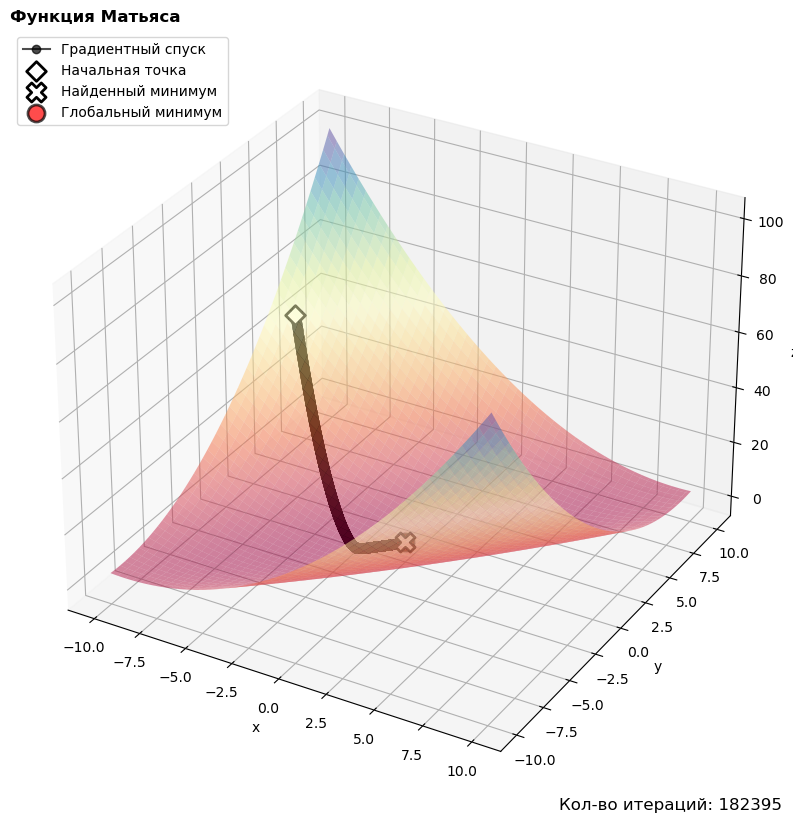

In [47]:
path = classic_GD(Matyas,
                  start_params=np.array([-9, 5]),
                  max_iter=1e7)

draw_result(Matyas, path)

## Градиентный спуск с инерцией

In [41]:
def inertial_GD(
    func: BenchmarkFunction, 
    start_params: np.ndarray, 
    max_iter: int = 10000, 
    lr: float = 0.001, 
    delta: float = 0.001, 
    beta: float = 0.5
    ) -> np.array:


    # Рассчитываем начальный набор параметров
    params_prev = start_params.copy()
    params = start_params.copy()
    path = [np.array([params[0], params[1], func.function(params)])]
    
    step = 0
    while (step < max_iter and norm(path[-1] - func.global_min) > delta):

        # Вычисляем новое значение параметров
        params_new = params - lr * func.grad(params) + beta * (params - params_prev)
        params_prev = params
        params = params_new
        
        # Логируем результат
        path.append(np.array([params[0], params[1], func.function(params)]))
        step += 1

    return np.array(path)

### Тестирование на функции Бута

Начальная точка:	[-7.00 -7.00 1460.00]
Найденный минимум:	[1.00e+00 3.00e+00 1.01e-06]
Кол-во итераций:	1805
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]


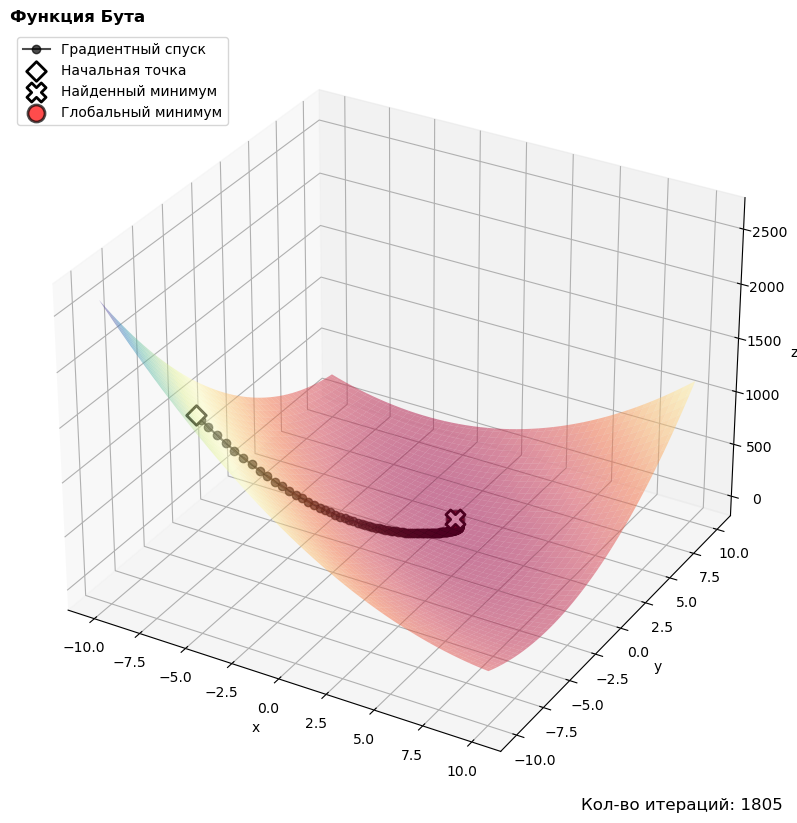

In [42]:
path = inertial_GD(Booth,
                  start_params=np.array([-7, -7]))

draw_result(Booth, path)

### Тестирование на функции Матьяса

Начальная точка:	[-9.00 5.00 49.16]
Найденный минимум:	[-7.07e-04 -7.07e-04 2.00e-08]
Кол-во итераций:	91190
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]


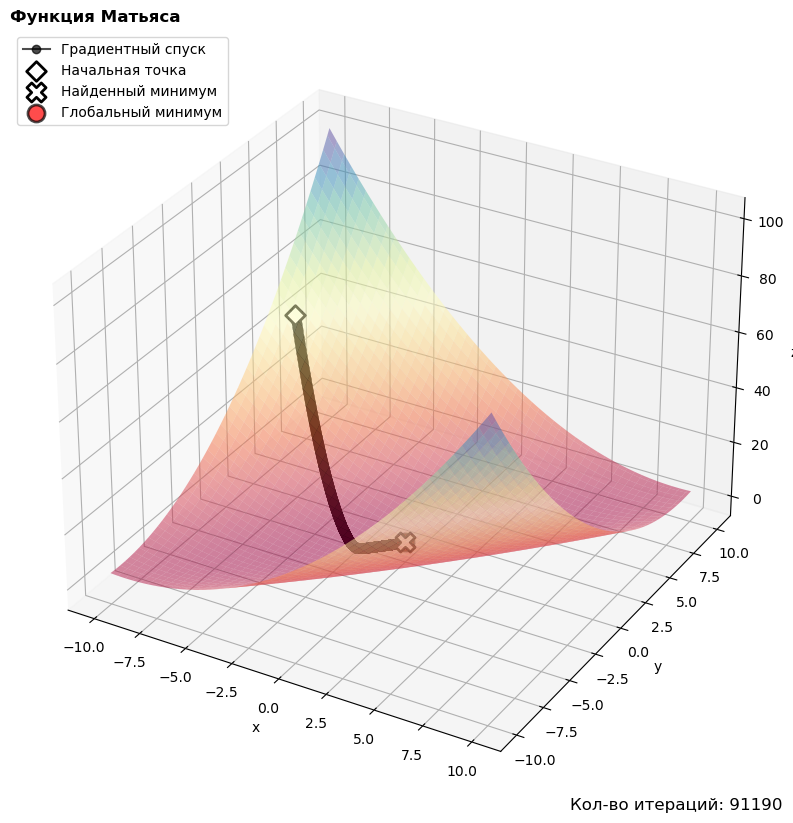

In [46]:
path = inertial_GD(Matyas,
                   start_params=np.array([-9, 5]),
                   max_iter=1e7)

draw_result(Matyas, path)

## ADAptive Momentum

In [54]:
def Adam_GD(
    func: BenchmarkFunction, 
    start_params: np.ndarray, 
    max_iter: int = 1000000, 
    lr: float = 0.001, 
    b1: float = 0.6, 
    b2: float = 0.999, 
    e: float = 10e-8, 
    delta: float = 0.001
    ) -> np.array:
    """ADAM

    Args:
        func (BenchmarkFunction): Тестируемая функция
        start_params (np.ndarray): Начальная точка
        max_iter (int, optional): Максимальное число итераций. Defaults to 1000000.
        lr (float, optional): Темп обучения. Defaults to 0.001.
        b1 (float, optional): beta1. Defaults to 0.6.
        b2 (float, optional): beta2. Defaults to 0.999.
        e (float, optional): Epsilon. Defaults to 10e-8.
        delta (float, optional): Delta. Defaults to 0.001.

    Returns:
        np.array: Путь
    """

    params = start_params.copy()
    path = [np.array([params[0], params[1], func.function(params)])]

    m = np.array([0, 0])
    v = np.array([0, 0])
    
    step = 0
    while (step < max_iter and norm(path[-1] - func.global_min) > delta)Ж
        m = b1 * m + (1 - b1) * func.grad(params)
        v = b2 * v + (1 - b2) * func.grad(params) ** 2

        params = params - lr * m / (np.sqrt(v) + e)
        
        path.append(np.array([params[0], params[1], func.function(params)]))
        step += 1

    return np.array(path)

### Тестирование на функции Бута

Начальная точка:	[-7.00 -7.00 1460.00]
Найденный минимум:	[1.00e+00 3.00e+00 1.00e-06]
Кол-во итераций:	17075
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]


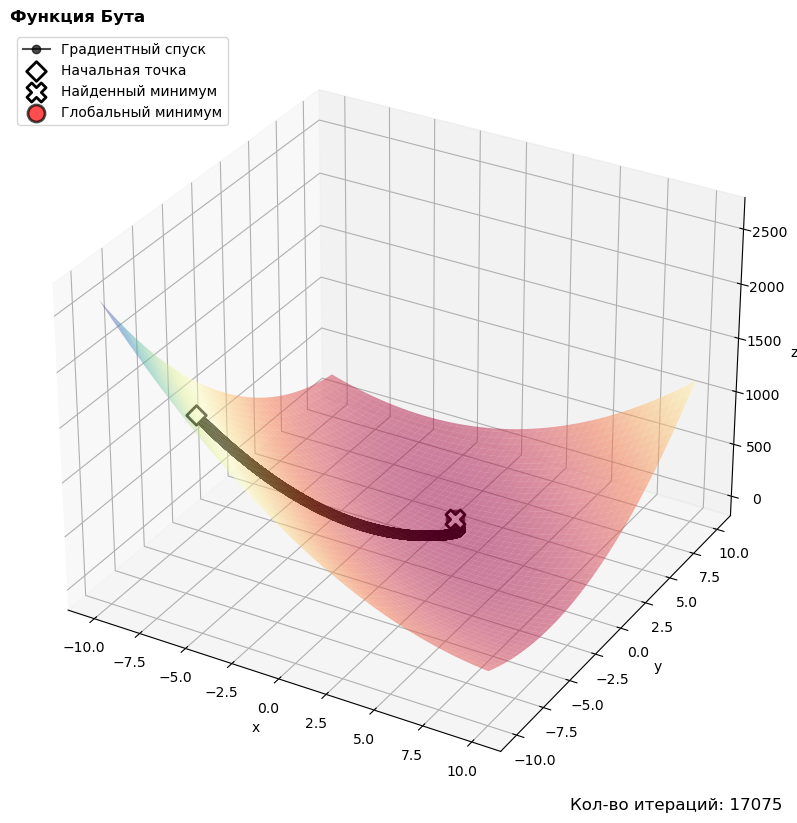

In [55]:
path = Adam_GD(Booth,
               start_params=np.array([-7, -7]))

draw_result(Booth, path)

### Тестирование на функции Матьяса

Начальная точка:	[-9.00 5.00 49.16]
Найденный минимум:	[-7.08e-04 -6.97e-04 1.98e-08]
Кол-во итераций:	17107
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]


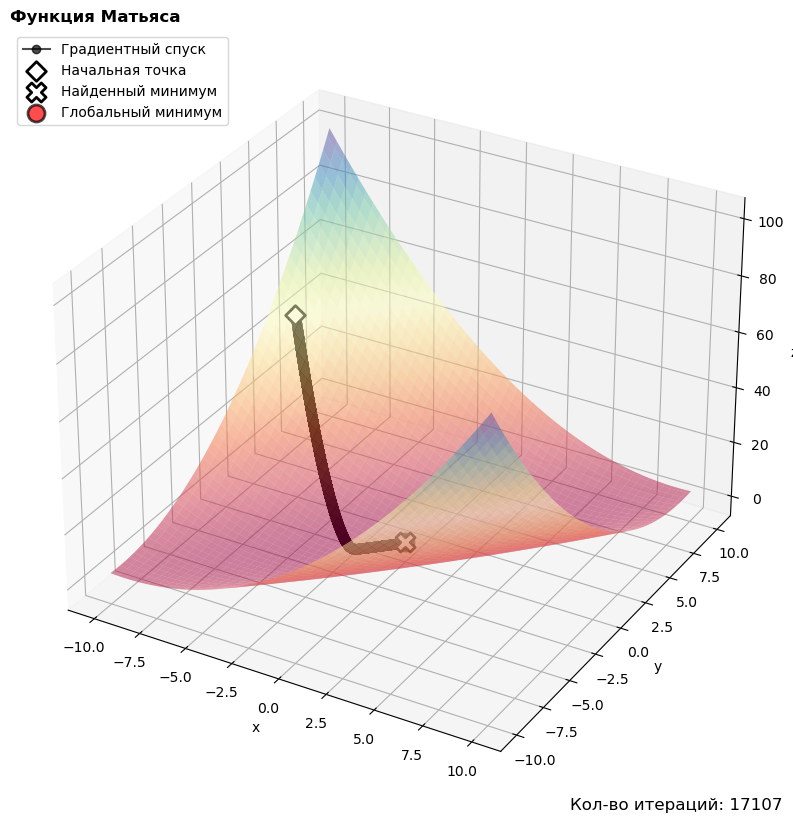

In [56]:
path = Adam_GD(Matyas,
               start_params=np.array([-9, 5]))

draw_result(Matyas, path)

## Классический градиентный спуск с изменяемым темпом обучения

In [79]:
def classic_GD_with_varying_lr(
    func: BenchmarkFunction, 
    start_params: np.ndarray,
    lr: float = 0.05,
    d: float = 0.001,
    max_iter: int = 10000,
    delta: float = 0.001
    ) -> np.array:
    """Классический градиентный спуск с изменением величины темпа обучения

    Args:
        func (BenchmarkFunction): Функция.
        start_params (np.ndarray): Начальные параметры.
        lr (float, optional): Начальный темп обучения.
        d (float, optional): Величина затухания. Defaults to 0.1.
        max_iter (int, optional): Количество шагов. Defaults to 10000.
        delta (float, optional): Величина приблежения. Defaults to 0.001.

    Returns:
        np.array: Путь.
    """
    
    params = start_params.copy()
    path = [np.array([params[0], params[1], func.function(params)])]
    
    step = 0

    while (step < max_iter and norm(path[-1] - func.global_min) > delta):
        params = params - lr * func.grad(params)
        
        path.append(np.array([params[0], params[1], func.function(params)]))
        step += 1
        lr = lr / (1 + step * d)

    return np.array(path)

### Тестирования на функции Бута

Начальная точка:	[-7.00 -7.00 1460.00]
Найденный минимум:	[1.00e+00 3.00e+00 1.01e-06]
Кол-во итераций:	534
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]


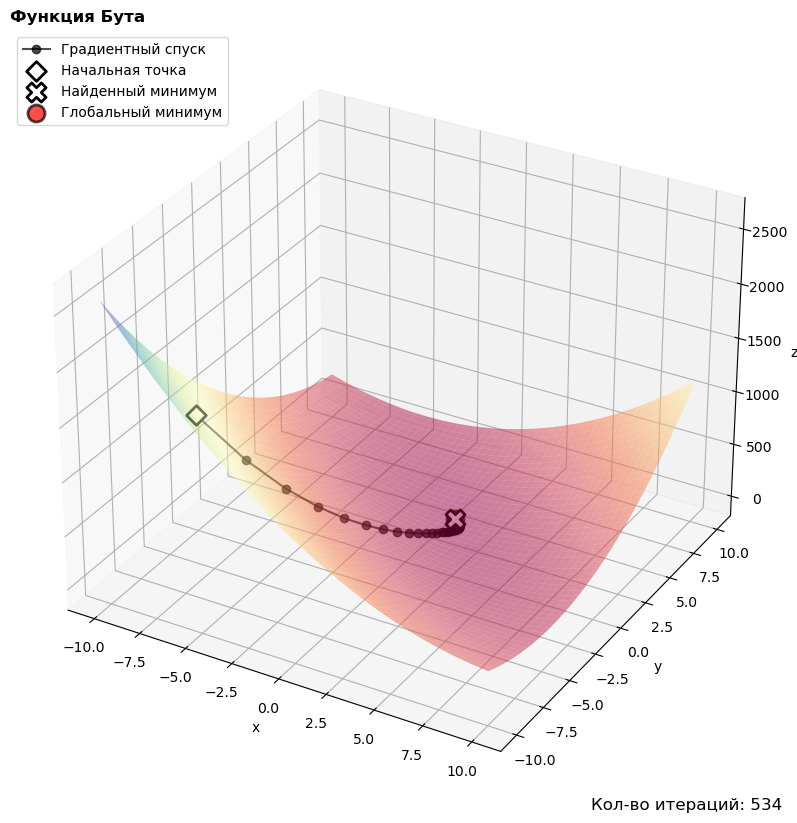

In [90]:
path = classic_GD_with_varying_lr(Booth,
               start_params=np.array([-7, -7]),
               lr=0.01,
               d=1e-5)

draw_result(Booth, path)

### Тестирование на функции Матьяса

Начальная точка:	[-9.00 5.00 49.16]
Найденный минимум:	[-7.02e-04 -7.02e-04 1.97e-08]
Кол-во итераций:	543
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]


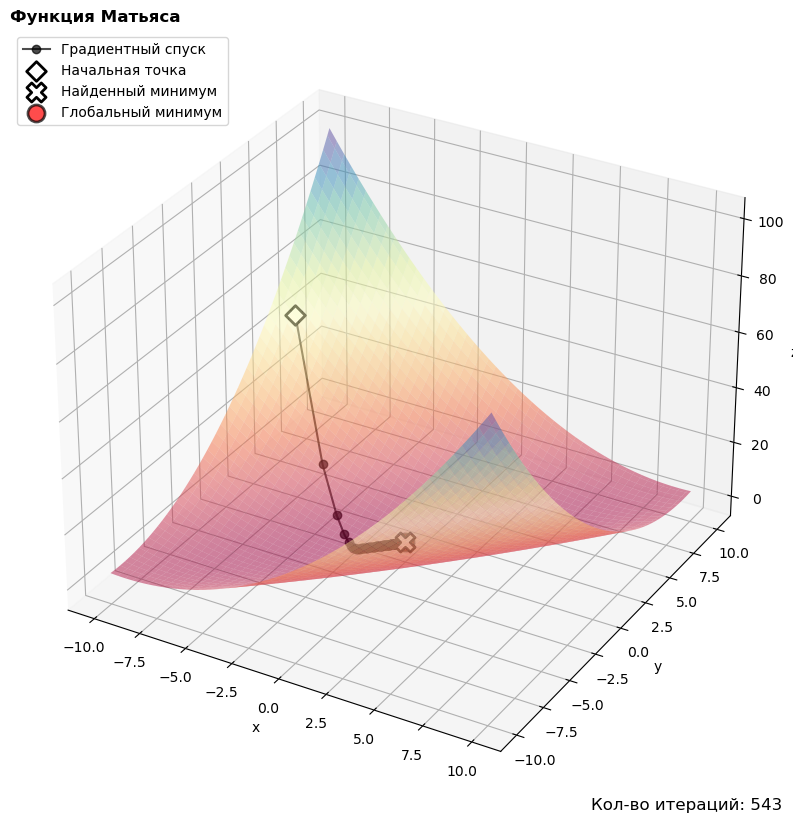

In [85]:
path = classic_GD_with_varying_lr(Matyas,
                                  start_params=np.array([-9, 5]),
                                  max_iter=1e5,
                                  lr=0.5,
                                  d=1e-5)

draw_result(Matyas, path)